In [2]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Determine the directory of the current notebook
notebook_dir = os.getcwd()

# Add the parent 'code' directory to sys.path for db_connector.py
code_dir = os.path.abspath(os.path.join(notebook_dir, '../../'))
sys.path.append(code_dir)

# Ensure the credentials file path is set relative to db_connector.py
credentials_file_path = os.path.join(code_dir, "db_credentials.json")

# Verify that the credentials file exists
if not os.path.exists(credentials_file_path):
    raise FileNotFoundError(f"Credentials file not found at {credentials_file_path}. Please ensure it exists.")

# Import the db_connector module
import db_connector

# Override the default path for the credentials file
db_connector.credentials_file = credentials_file_path

# Use get_credentials and connect_to_database
credentials = db_connector.get_credentials()

try:
    engine = db_connector.connect_to_database(credentials)
    print("Connected to the database successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Credentials loaded from file.
Connected to the database successfully.


In [4]:
def fetch_customer_distribution(engine):
    """
    Retrieve customer distribution and revenue contribution by country.
    """
    query = """
    SELECT 
        Country, 
        COUNT(DISTINCT CustomerID) AS UniqueCustomers,
        SUM(Quantity * UnitPrice) AS Revenue
    FROM clean_uci_online_retail
    WHERE CustomerID IS NOT NULL
    GROUP BY Country
    ORDER BY Revenue DESC;
    """
    data = pd.read_sql(query, con=engine)
    return data

In [5]:
def generate_customer_distribution_plot(data):
    """
    Generate Customer Distribution by Country plot.
    """
    # Ensure only the top 10 countries by revenue are included
    data = data.head(10)

    # Set Seaborn style without gridlines
    sns.set_theme(style="white")

    # Create a dual-axis bar plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Bar plot for Revenue
    sns.barplot(x='Country', y='Revenue', data=data, ax=ax1, palette="Blues_d")
    ax1.set_ylabel('Revenue (\u00a3)', fontsize=12, fontstyle='italic')
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    ax1.set_xlabel('Country', fontsize=12, fontstyle='italic')
    ax1.set_title('Top 10 Countries by Customer Distribution and Revenue Contribution', fontsize=16, fontweight='bold')

    # Line plot for Unique Customers
    ax2 = ax1.twinx()
    sns.lineplot(x='Country', y='UniqueCustomers', data=data, ax=ax2, color="orange", marker="o")
    ax2.set_ylabel('Number of Unique Customers', fontsize=12, fontstyle='italic')

    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45)

    # Add annotations for the number of unique customers with adjusted placement
    for i, value in enumerate(data['UniqueCustomers']):
        if data['Country'][i] == 'United Kingdom':
            offset = 0.02 * max(data['UniqueCustomers'])  # Lower the label slightly
        else:
            offset = 0.05 * max(data['UniqueCustomers'])
        ax2.text(i, value + offset, f"{value:,}", ha='center', fontsize=9, color='black')

    plt.tight_layout()

    # Save the plot
    plot_path = '../../../plots/customer_distribution_by_country.png'
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")

    # Show the plot
    plt.show()

Plot saved to ../../../plots/customer_distribution_by_country.png


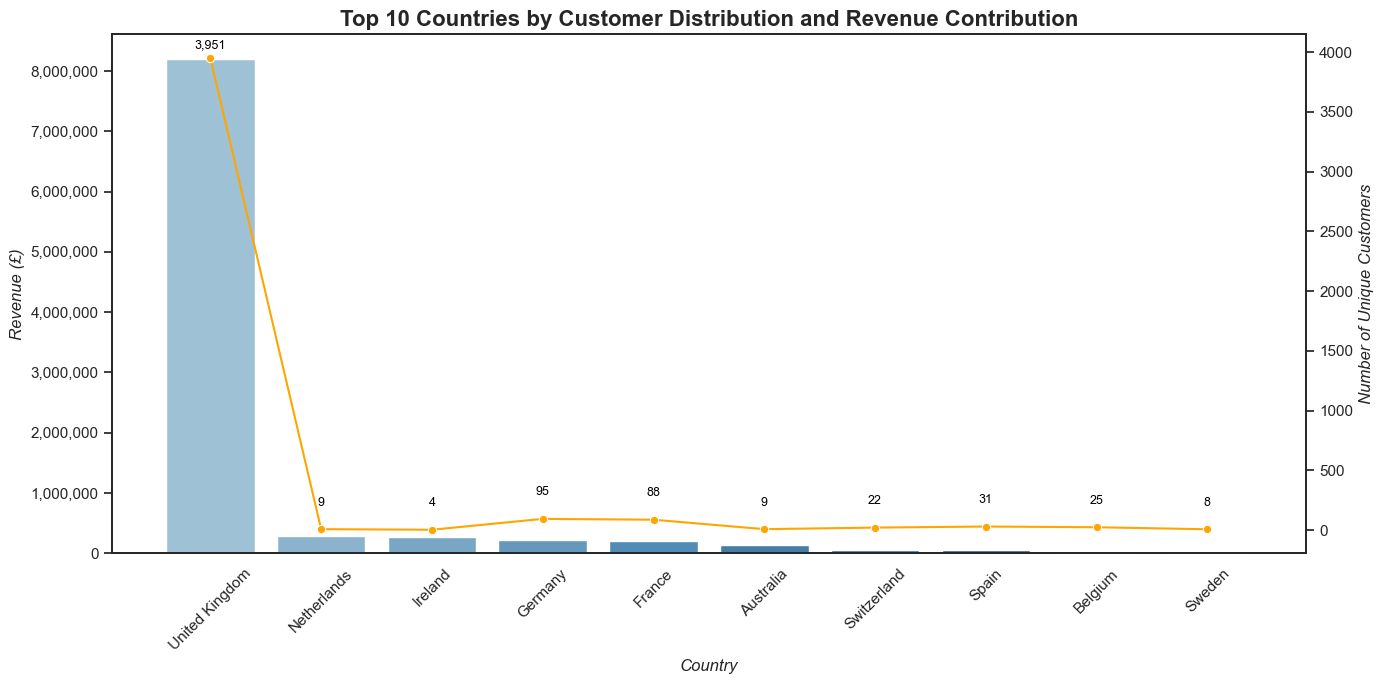

In [6]:
# Main execution
if __name__ == "__main__":
    try:
        # Fetch customer distribution data
        customer_data = fetch_customer_distribution(engine)
        generate_customer_distribution_plot(customer_data)

    except Exception as e:
        print(f"An error occurred: {e}")

**Insights & Interpretation**

1. Customer Concentration in the United Kingdom
    * Similar to revenue, the United Kingdom dominates customer distribution, with 3,951 unique customers contributing significantly more compared to other countries.
    * This reflects a heavy reliance not just on revenue but also on customer base from the UK, making it the primary driver of the business.
2. Disparity in Customer Numbers Across Countries
    * There is a drastic drop-off in customer numbers after the UK. For instance, Germany, the second-highest in unique customers, has only 95, a mere fraction of the UK’s customer base.
    * This disparity mirrors the revenue distribution, further emphasizing the overdependence on the UK.
3. High Revenue Per Customer in Other Countries
    * Countries like the Netherlands and Ireland, despite having relatively few unique customers (9 and 4, respectively), are still among the top contributors in revenue.
    * This suggests high spending per customer, which might indicate opportunities to further penetrate these markets with targeted strategies.
4. Potential Markets for Customer Growth
    * Countries such as Germany (95 customers) and France (88 customers) exhibit relatively higher customer counts among non-UK markets. However, their revenue contributions are lower compared to their customer numbers.
    * These regions might benefit from strategies to increase revenue per customer through upselling or premium product offerings.
5. Underperforming Markets
    * Countries like Australia (9 customers) and Switzerland (22 customers) appear in both the top 10 revenue and customer distribution but with relatively low numbers. These could represent untapped markets for customer acquisition and growth.
6. Geographic Dependence
    * The distribution again reflects a strong focus on European markets, with minimal representation outside Europe except for Australia. This reinforces the insight from the revenue analysis about diversifying and expanding into non-European markets to reduce dependency on a single region.
7. Balanced Growth Opportunities
    * While increasing revenue per customer is essential, expanding the customer base in high-potential markets like Germany and France should also be prioritized to create a more balanced distribution of both customers and revenue.